# Hierarchical Bayesian model of binary choice
(This notebook omits the comparison of priors. See previous notebook)

Imagine a world where everyone chooses whether or not to open their windows. This choice is random, but the probability has some regional influence.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy import stats
import numpy as np
import pymc3 as pm
import seaborn as sns

sns.set_style('darkgrid')

np.random.seed(434)

## Data
I make synthetic data:

In [2]:
# SECRET constants are the true population distribution that we can never know
SECRET_A = 2
SECRET_B = 5
SECRET_P_DIST = stats.beta(SECRET_A, SECRET_B)

In [3]:
REGIONS = ["North", "South", "East", "West"]

In [4]:
SECRET_P = SECRET_P_DIST.rvs(len(REGIONS))
SECRET_P

array([0.14360561, 0.07236543, 0.25310767, 0.32047349])

In [5]:
N_OBS = [150, 100, 50, 10]

In [6]:
observed_counts = [stats.binom.rvs(n, p) for n, p in zip(N_OBS, SECRET_P)]
observed_counts

[14, 6, 12, 3]

Sanity check that simulated observations make sense:

In [7]:
np.array(observed_counts)/np.array(N_OBS)

array([0.09333333, 0.06      , 0.24      , 0.3       ])

In [8]:
observed_p = np.array(observed_counts)/np.array(N_OBS)
observed_p

array([0.09333333, 0.06      , 0.24      , 0.3       ])

In [16]:
[stats.binom.cdf(k, n, p) for k, n, p in zip(observed_counts, N_OBS, SECRET_P)]

[0.044894014384980176,
 0.40838867611425533,
 0.4906670675401894,
 0.5943487464308739]

So North got a ~5% unlikely fluctuation (since this is a post-hoc test, we shouldn't interpret this too carefully e.g. it is not a p value).

Outside of this section, we cannot use SECRET variables because they are the true parameters we can never know exactly.

# Model
Based on https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html

In [9]:
with pm.Model() as model:
    # see e.g. https://arxiv.org/abs/1104.4937 for support of half Cauchy priors
    a = pm.HalfCauchy("a", beta=1)
    b = pm.HalfCauchy("b", beta=1)

    theta = pm.Beta('theta', alpha=a, beta=b, shape=len(REGIONS))

    p = pm.Binomial('p', p=theta, observed=observed_counts, n=N_OBS)
    trace = pm.sample(5000, tune=1000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, b, a]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 24000/24000 [00:17<00:00, 1355.95draws/s]


C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Immanuel\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000299C3667908>,
      dtype=object)

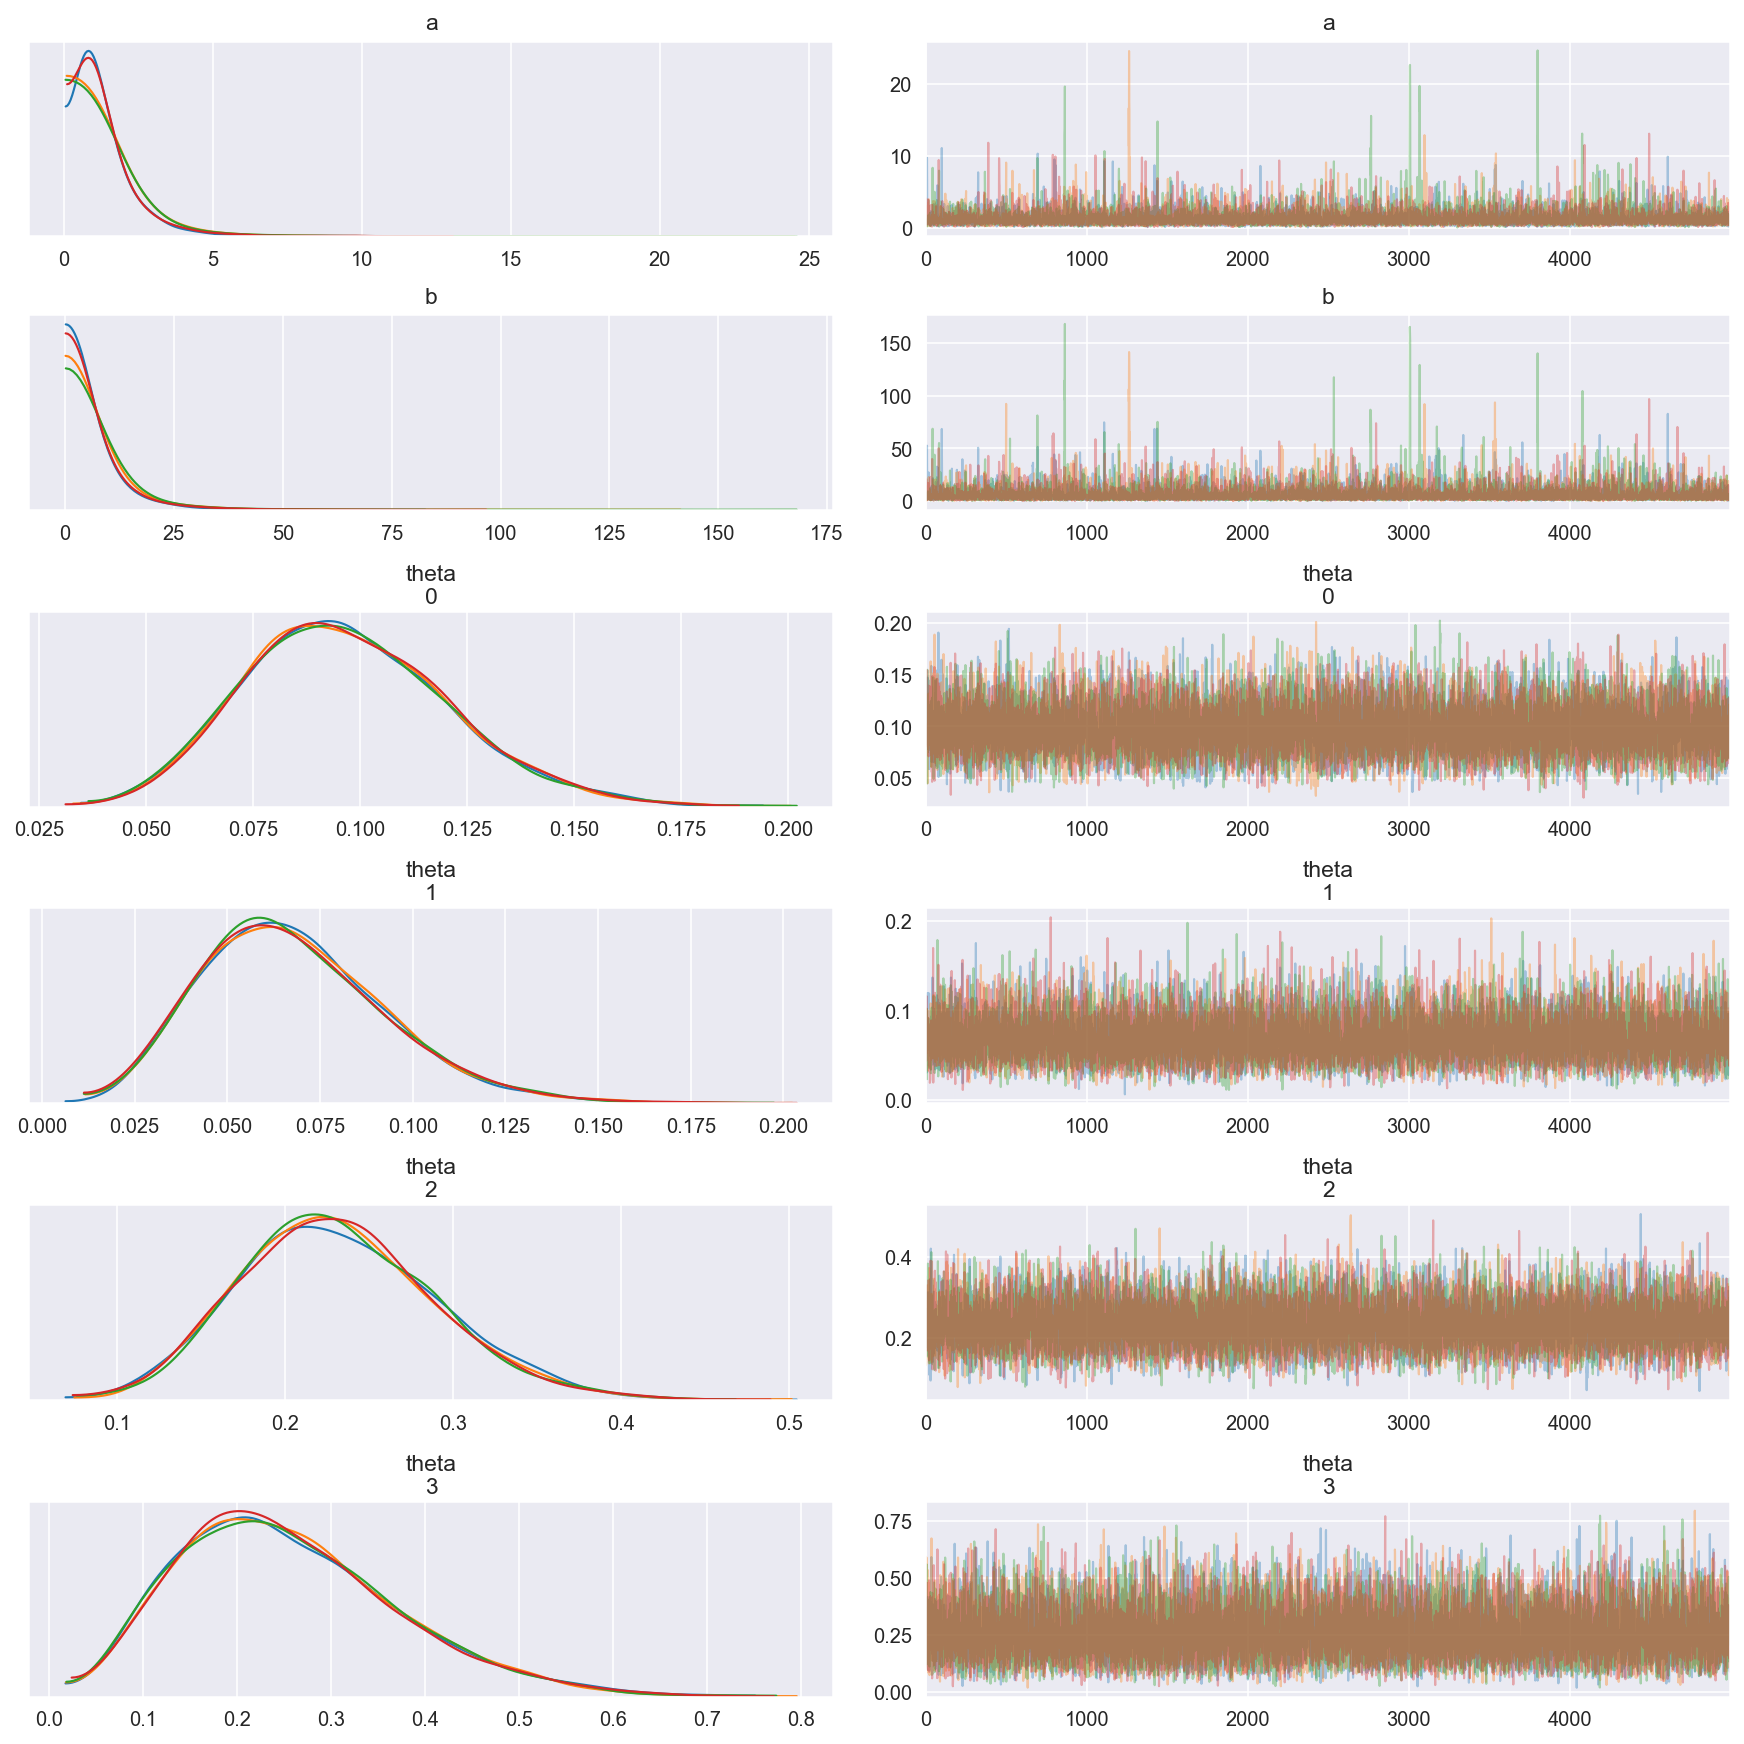

In [10]:
pm.traceplot(trace)

In [11]:
pm.summary(trace)

C:\Users\Immanuel\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.394959,1.217665,0.017467,0.134833,3.412817,6762.537783,1.000695
b,6.886943,8.238766,0.116813,0.186959,20.779647,6667.044995,1.000706
theta__0,0.097090,0.023722,0.000172,0.052908,0.144319,18124.326496,0.999966
theta__1,0.068091,0.024613,0.000177,0.024864,0.117443,16706.548375,0.999964
theta__2,0.231997,0.057458,0.000473,0.125131,0.346878,16386.610811,0.999957
theta__3,0.255874,0.115412,0.001017,0.060908,0.487092,15100.223555,0.999918


The effect of the divergences and of changing priors on $\theta$ was mild.

# Posterior check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000299C3662128>,
      dtype=object)

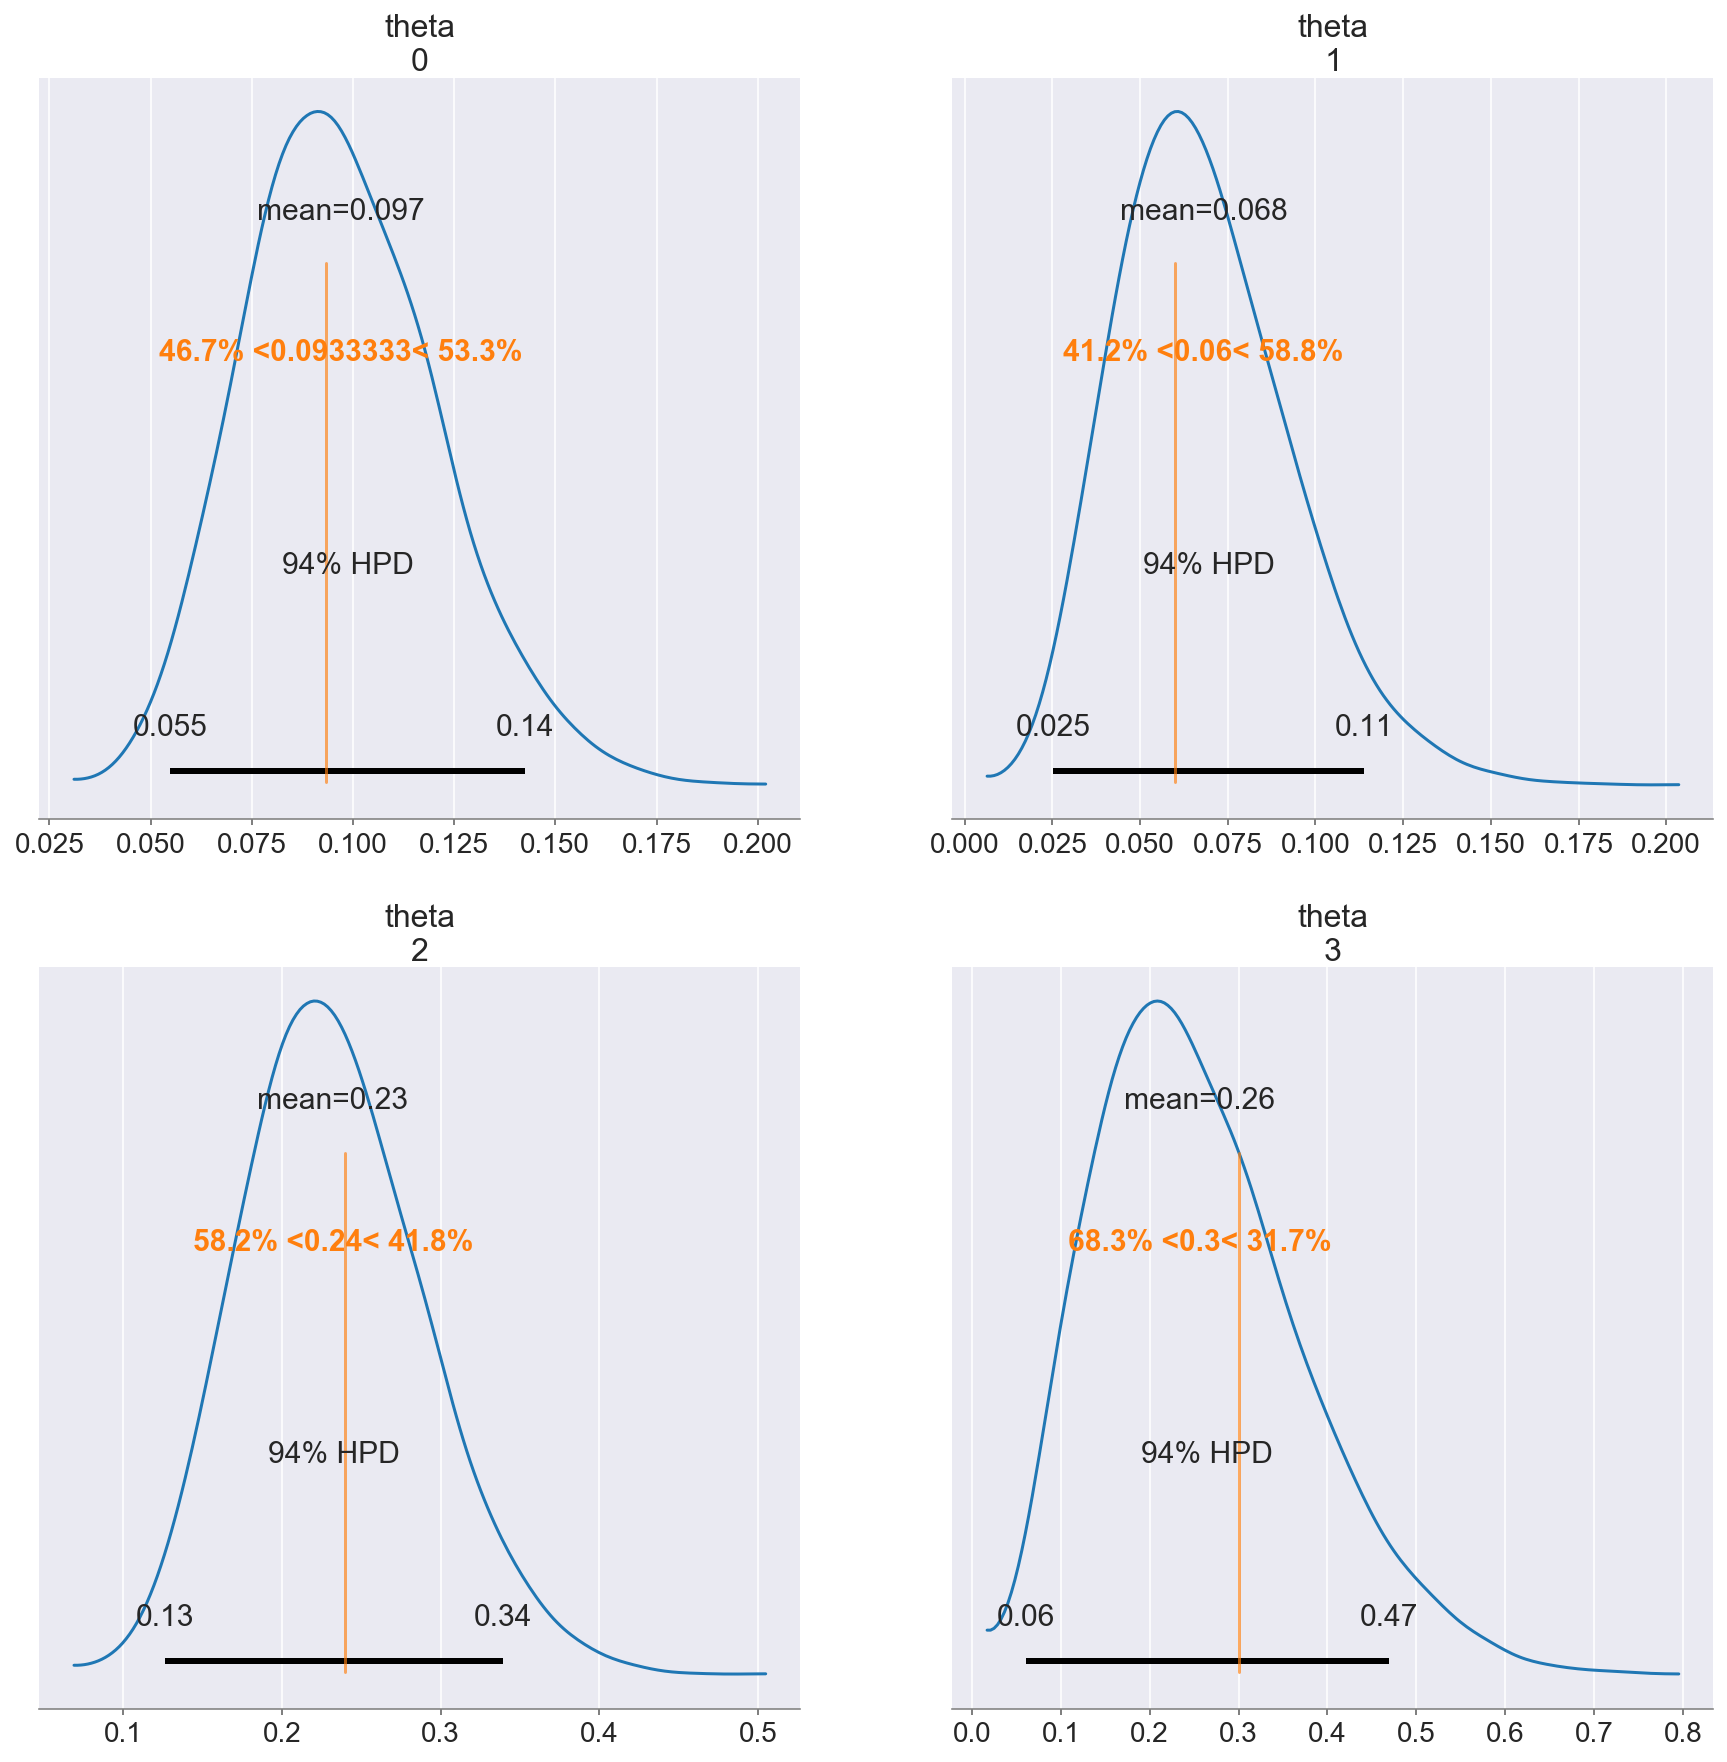

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,15,))
pm.plot_posterior(trace, var_names=["theta"], ax=axs, ref_val=list(observed_p))

This plot shows the true parameters (that we could never observe directly, but useful as a consistency check of the model):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000299C8C2F780>,
      dtype=object)

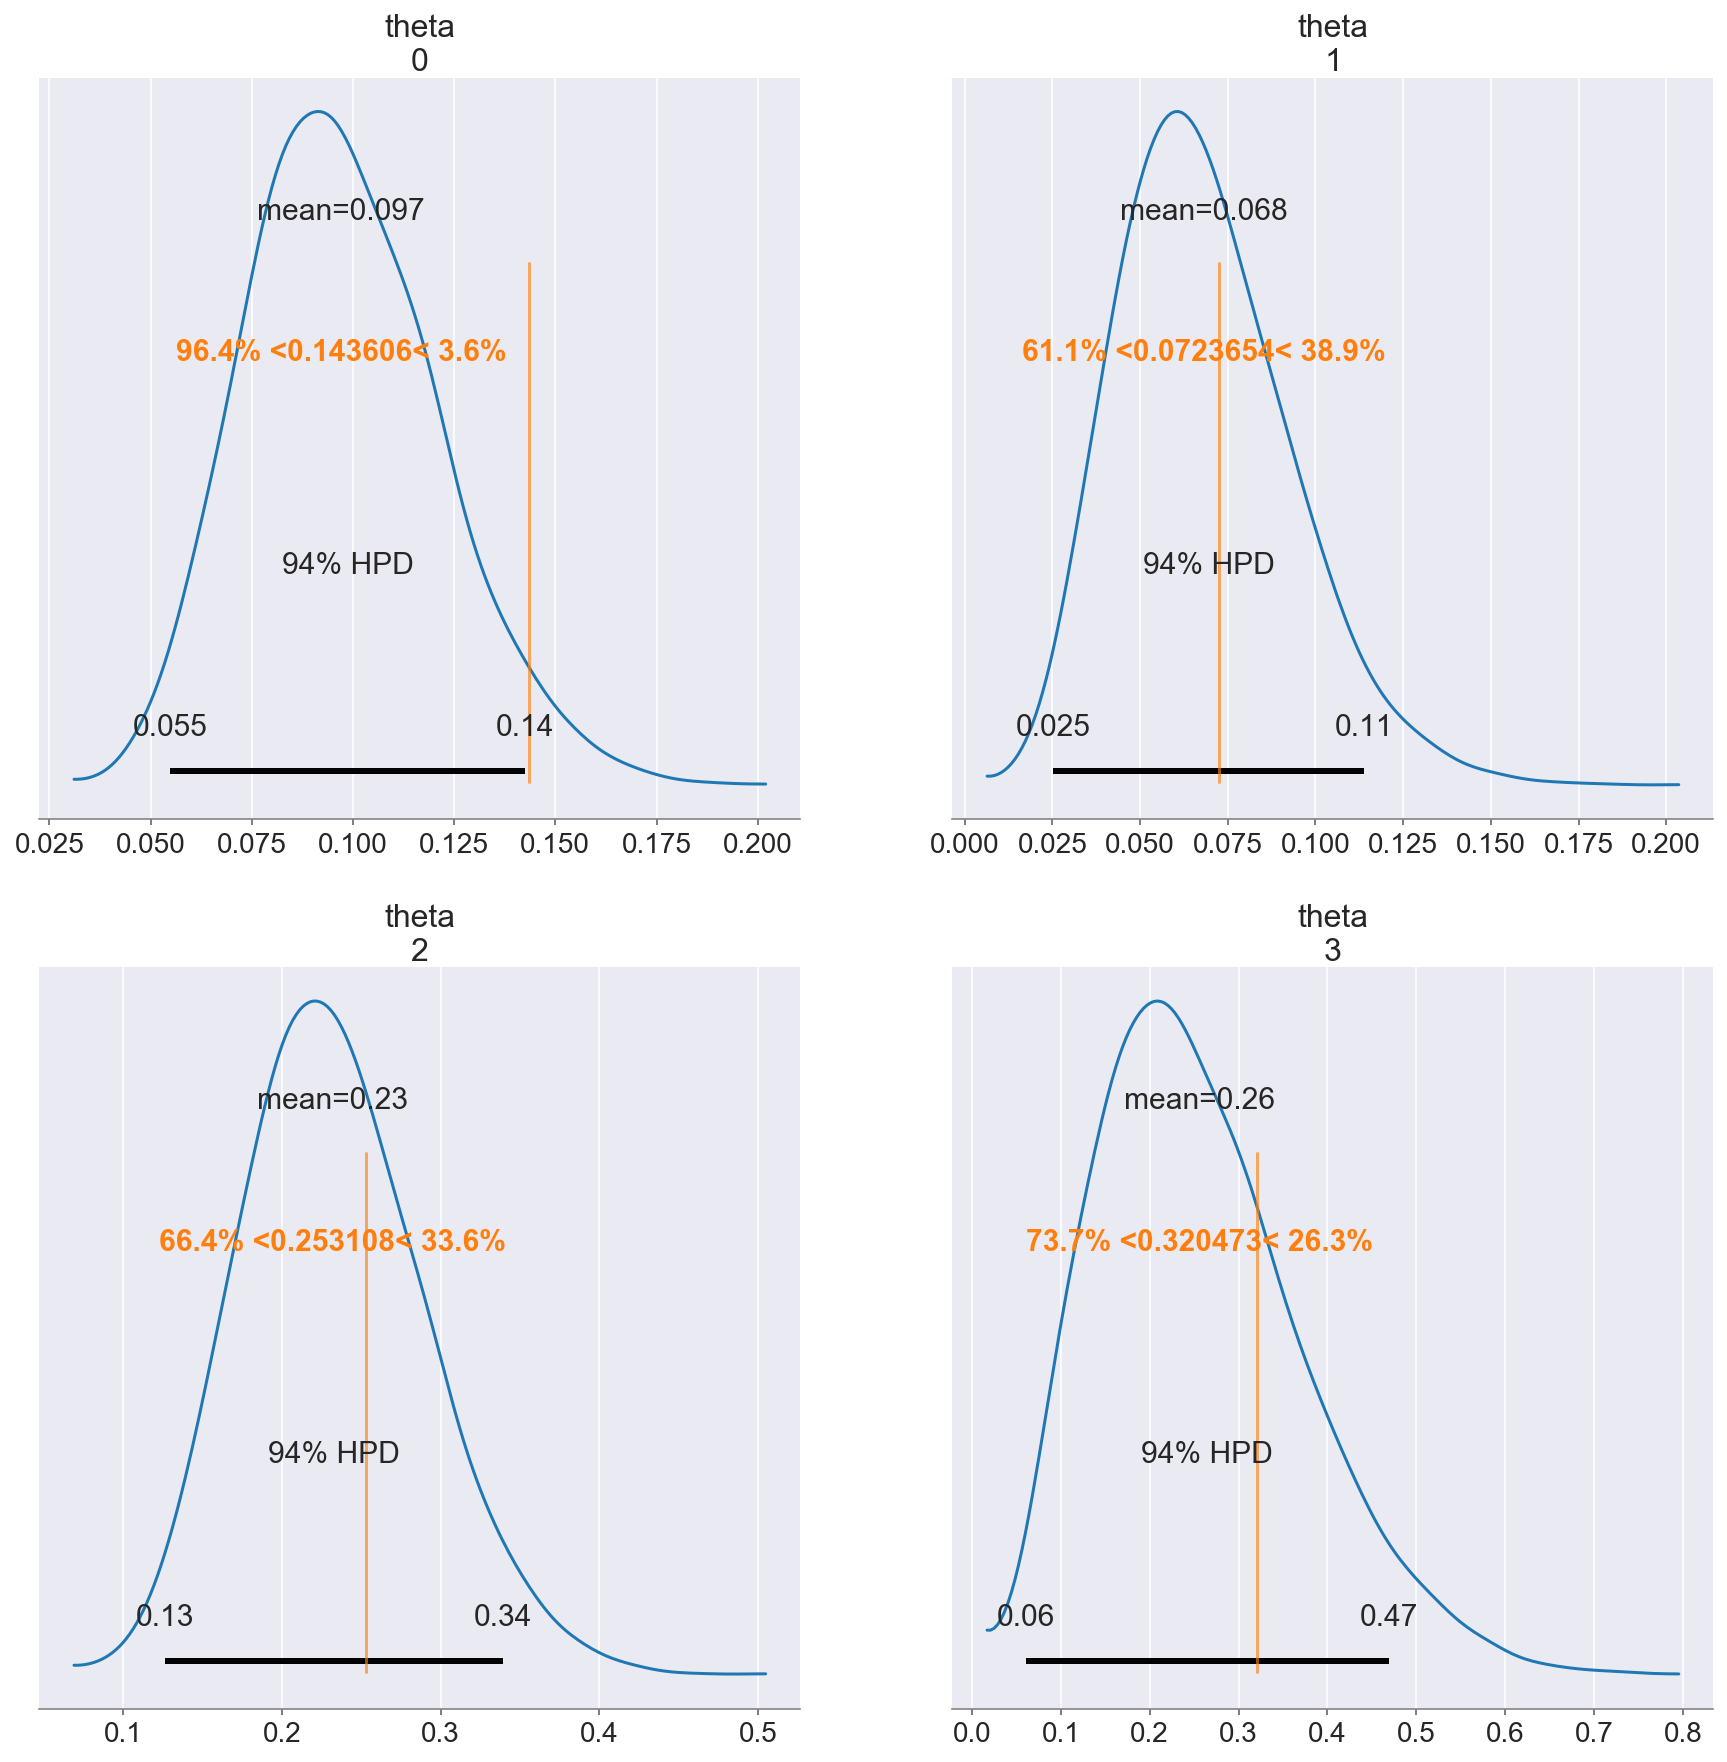

In [13]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,15,))
pm.plot_posterior(trace, var_names=["theta"], ax=axs, ref_val=list(SECRET_P))